In [1]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from rpcc_metric_utils_for_participants_v2 import contest_metric, sive_diam_pan, calc_chi_square_metric
import os

import torch
import torch.nn as nn
from torch.optim import Adam

import albumentations as A
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, Dataset

root_path = '/kaggle/input/rpcc-train'

In [2]:
train = pd.read_csv(os.path.join(root_path, "RPCC_labels.csv"))
sieve_sizes = pd.read_csv(os.path.join(root_path, "RPCC_sieve_sizes.csv"))
sample = pd.read_csv(os.path.join(root_path, "sample.csv"))

In [3]:
train_df, test_df = train_test_split(train, test_size=0.02, random_state=42)
train_df = train

In [4]:
train_cnt = train_df[~train_df.prop_count.isnull()]
train_dist = train_df[~train_df.pan.isnull()]

valid_cnt = test_df[~test_df.prop_count.isnull()]
valid_dist = test_df[~test_df.pan.isnull()]

train_cnt.shape, train_dist.shape, valid_cnt.shape, valid_dist.shape

((64, 23), (756, 23), (1, 23), (15, 23))

In [5]:
# GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(not torch.cuda.is_available()):
    print('Current device - CPU')
else:
    print(device)

cuda:0


# Count props part

In [6]:
class CntDataset(Dataset):
    def __init__(self, path, df, transforms):
        self.path = path
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self, item):
        path = os.path.join(self.path, f"{self.df.ImageId.iloc[item]}.jpg")
        label = torch.Tensor([self.df.prop_count.iloc[item]])
        
        #read the image with OpenCV
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = self.transforms(image=img)['image']
        img = torch.from_numpy(img)
        return img.permute(2, 0, 1), label
    
    def __len__(self):
        return len(self.df)

In [7]:
max_cnt = train_cnt.prop_count.max()
min_cnt = train_cnt.prop_count.min()
print(min_cnt, max_cnt)

norm = lambda cnt: (cnt - min_cnt) / (max_cnt - min_cnt)
# denormalization
inorm = lambda cnt: cnt * (max_cnt - min_cnt) + min_cnt

assert inorm(norm(1500)) == 1500

688.0 3029.0


In [8]:
valid_cnt.prop_count

215    981.0
Name: prop_count, dtype: float64

In [9]:
# rewrite (see the notice)
train_cnt.prop_count = train_cnt.prop_count.apply(norm)
valid_cnt.prop_count = valid_cnt.prop_count.apply(norm)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
valid_cnt.prop_count

215    0.12516
Name: prop_count, dtype: float64

In [11]:
model = mobilenet_v2(True)
model.classifier[1] = nn.Linear(1280, 1, True)
#model = model.cuda()
model = model.to(device)

optimizer = Adam(model.parameters(), 1e-4)
#criterion = nn.MSELoss()
criterion = nn.MSELoss().to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [12]:
model.parameters

<bound method Module.parameters of MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96,

In [13]:
#def custom_resize():    

In [14]:
batch_size = 16
train_ds = CntDataset(
    os.path.join(root_path, "RPCC_train/train/"), 
    train_cnt, 
    A.Compose([
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225]),   
        A.Normalize(),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.ToGray(p=1),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=90, p=.5),
        A.Resize(512, 512)
    ])
)
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

valid_ds = CntDataset(
    os.path.join(root_path, "RPCC_train/train/"), 
    valid_cnt, 
    A.Compose([
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225]),
        A.Normalize(),
        #A.ToGray(p=1),
        A.Resize(512, 512)
    ])
)
valid_loader = DataLoader(valid_ds, batch_size, shuffle=False)


test_ds = CntDataset(
    os.path.join(root_path, "RPCC_train/train/"), 
    test_df, 
    A.Compose([
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225]),
        A.Normalize(),
        #A.ToGray(p=1),
        A.Resize(512, 512)
    ])
)
test_loader = DataLoader(test_ds, batch_size, shuffle=False)

images.shape: torch.Size([16, 3, 512, 512])


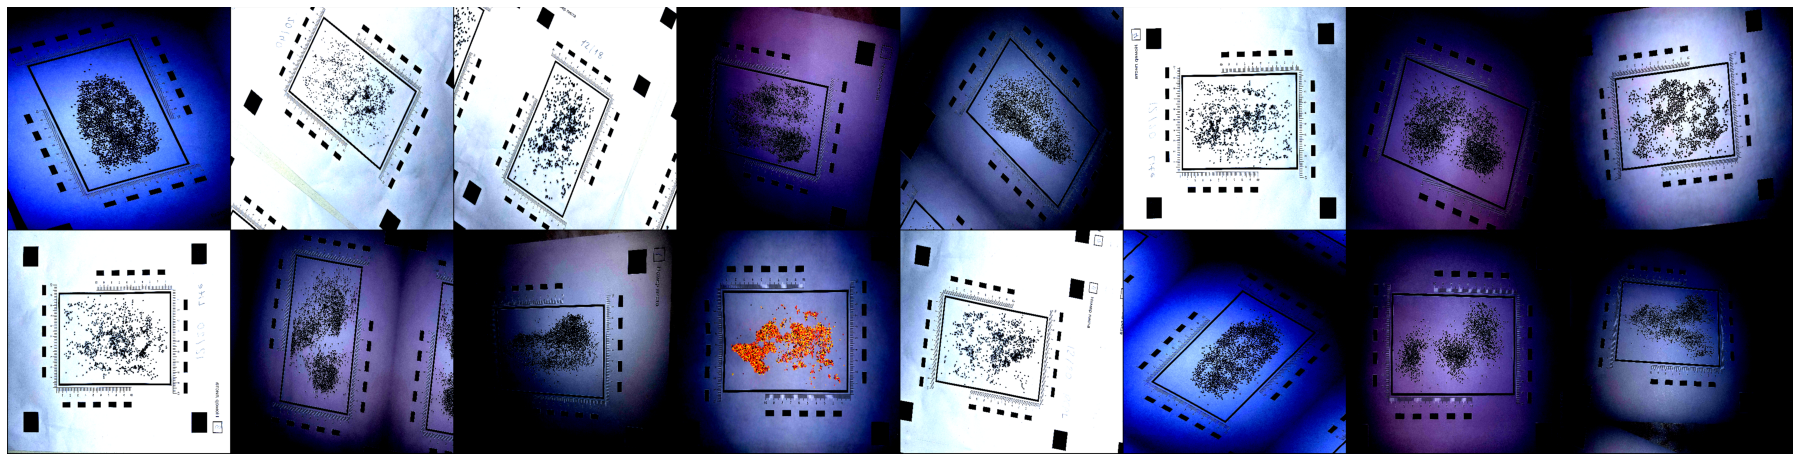

In [15]:
# batch with images (16 ) for train
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(32,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [16]:
def train_epoch(num, loader):
    model.train()
    running_loss = 0.
    for i, (batch, labels) in enumerate(loader):
        #batch = batch.cuda()
        #labels = labels.cuda()
        batch = batch.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("Train Epoch: ", num + 1, "Loss: ", running_loss / (i+1))

    
def predict(loader):
    model.eval()
    outputs = []
    with torch.no_grad():
        for i, (batch, _) in enumerate(loader):
            #batch = batch.cuda()
            batch = batch.to(device)
            outputs.extend(model(batch).cpu().detach().numpy().squeeze().tolist())
    return outputs
    
    
def eval_epoch(num, loader):
    outputs = predict(loader)
    #print("Outputs: ", outputs)
    pred_cnts = np.array([inorm(x) for x in outputs])
    #print("pred_cnts: ", pred_cnts)
    gt_cnts = np.array([inorm(x) for x in loader.dataset.df.prop_count])
    #print("gt_cnts: ", gt_cnts)
    print("Eval Epoch: ", num + 1, "MAPE: ", np.mean(np.abs(pred_cnts - gt_cnts) / gt_cnts))
    

def train_and_eval():
    for epoch in range(10):
        train_epoch(epoch, train_loader)
        #eval_epoch(epoch, valid_loader)
        print("=" * 10)


train_and_eval()

Train Epoch:  1 Loss:  0.44821644574403763
Train Epoch:  2 Loss:  0.181710135191679
Train Epoch:  3 Loss:  0.07937931641936302
Train Epoch:  4 Loss:  0.08068804815411568
Train Epoch:  5 Loss:  0.08981744758784771
Train Epoch:  6 Loss:  0.05661647021770477
Train Epoch:  7 Loss:  0.04361124895513058
Train Epoch:  8 Loss:  0.05835693050175905
Train Epoch:  9 Loss:  0.04882320947945118
Train Epoch:  10 Loss:  0.0506379883736372


In [17]:
test_df.shape

(16, 23)

In [18]:
outputs = predict(test_loader)
cnt_preds = [inorm(x) for x in outputs]

In [19]:
cnt_preds

[2838.294607281685,
 2170.7203842401505,
 2932.440190911293,
 2820.2067534923553,
 2839.9271606206894,
 303.55768859386444,
 2403.5395135879517,
 2904.336831688881,
 2569.0050735473633,
 2573.6376180648804,
 2639.711377263069,
 2789.6325178146362,
 2779.468268632889,
 2534.1139203310013,
 2993.29926776886,
 3020.502629637718]

In [20]:
torch.save(model.cpu(), "model_cnts.pth")

# Count distr part

In [21]:
import os


class DistDataset(Dataset):
    def __init__(self, path, df, transforms):
        self.path = path
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self, item):
        path = os.path.join(self.path, f"{self.df.ImageId.iloc[item]}.jpg")
        label = torch.from_numpy(self.df.iloc[item, 1:-2].values.astype(np.float32))
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = self.transforms(image=img)['image']
        img = torch.from_numpy(img)
        return img.permute(2, 0, 1), label
    
    def __len__(self):
        return len(self.df)

In [22]:
model = mobilenet_v2(True)
model.classifier[1] = nn.Linear(1280, 20, True)
#model = model.cuda()
model = model.to(device)

optimizer = Adam(model.parameters(), 7e-4)
criterion = nn.MSELoss().to(device)

In [23]:
train_ds = DistDataset(
    os.path.join(root_path, "RPCC_train/train/"), 
    train_dist, 
    A.Compose([
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225]),   
        A.Normalize(),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.ToGray(p=1),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=90, p=.5),
        A.Resize(512, 512)
    ]),
)
train_loader = DataLoader(train_ds, 16, shuffle=True)

valid_ds = DistDataset(
    os.path.join(root_path, "RPCC_train/train/"), 
    valid_dist, 
    A.Compose([
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225]),
        A.Normalize(),
        #A.ToGray(p=1),
        A.Resize(512, 512)
    ]),
)

valid_loader = DataLoader(valid_ds, 16, shuffle=False)

test_ds = DistDataset(
    os.path.join(root_path, "RPCC_train/train/"), 
    test_df, 
    A.Compose([
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225]),
        A.Normalize(),
        #A.ToGray(p=1),
        A.Resize(512, 512)
    ]),
)

test_loader = DataLoader(test_ds, 16, shuffle=False)

In [24]:
def train_epoch(num, loader):
    model.train()
    running_loss = 0.
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        #batch = batch.cuda()
        #labels = labels.cuda()
        batch = batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(batch)
        loss = criterion(outputs.softmax(dim=1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print("Train Epoch: ", num + 1, "Loss: ", running_loss / (i+1))

    
def predict(loader):
    model.eval()
    outputs = []
    with torch.no_grad():
        for i, (batch, _) in enumerate(loader):
            #batch = batch.cuda()
            batch = batch.to(device)
            outputs.extend(model(batch).softmax(dim=1).cpu().detach().numpy().squeeze().tolist())
    return outputs
    
    
def eval_epoch(num, loader):
    outputs = predict(loader)
    gt_hists = loader.dataset.df.iloc[:, 1:-2].values
    gt_fracts = loader.dataset.df["fraction"].values
    res = []
    for i, (hist, fracts) in enumerate(zip(gt_hists, gt_fracts)):
        res.append(calc_chi_square_metric(hist, outputs[i], fracts))

    print("Eval Epoch: ", num + 1, "CHI2: ", np.mean(res))    

def train_and_eval():
    for epoch in range(9):
        train_epoch(epoch, train_loader)
        eval_epoch(epoch, valid_loader)
        print("=" * 10)


train_and_eval()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Train Epoch:  1 Loss:  0.005525793261767831
Eval Epoch:  1 CHI2:  0.05986371004180827



Train Epoch:  2 Loss:  0.0031634602758761807
Eval Epoch:  2 CHI2:  0.03988148915566204



Train Epoch:  3 Loss:  0.00291378684657199
Eval Epoch:  3 CHI2:  0.035697547507753134



Train Epoch:  4 Loss:  0.0025423579839601493
Eval Epoch:  4 CHI2:  0.0318503241302203



Train Epoch:  5 Loss:  0.002494951421491957
Eval Epoch:  5 CHI2:  0.04113086353286542



Train Epoch:  6 Loss:  0.002294557683247452
Eval Epoch:  6 CHI2:  0.028672826677435356



Train Epoch:  7 Loss:  0.0022050980587664526
Eval Epoch:  7 CHI2:  0.031993466731648566



Train Epoch:  8 Loss:  0.0024612425986560993
Eval Epoch:  8 CHI2:  0.03621169451714956



Train Epoch:  9 Loss:  0.002262164022492167
Eval Epoch:  9 CHI2:  0.025780734479121832


In [25]:
dist_preds = predict(test_loader)

In [26]:
torch.save(model.cpu(), "model_dists.pth")

In [27]:
def get_submit(cnt_preds, dist_preds, indices):
    submit = []
    for idx, cnt, dist in zip(indices, cnt_preds, dist_preds):
        cnt = int(cnt)
        sizes = np.random.choice(sive_diam_pan, size=cnt, p=dist / np.sum(dist))
        submit.extend([{
            "ImageId": idx,
            "prop_size": sizes[i]
        } for i in range(cnt)])
    return pd.DataFrame.from_records(submit)

In [28]:
predictions = get_submit(cnt_preds, dist_preds, test_loader.dataset.df.ImageId.values)

In [29]:
%%time
contest_metric(test_df, predictions)

CPU times: user 70.4 ms, sys: 6.17 ms, total: 76.6 ms
Wall time: 120 ms


(0.291375785046401, 0.024871976096702955, 0.691131498470948)